In [1]:
sc.stop()
from pyspark import SparkConf, SparkContext
#setMaster() = Set Spark Content Manager which is local[cpu cores]
config = SparkConf().setMaster('local[2]').setAppName("Assignment8")
sc = SparkContext(conf = config)
sc

<SparkContext master=local[2] appName=Assignment8>

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('PysparkSQLAssignment').getOrCreate()
spark

In [3]:
telecom_df = spark.read.csv("file:///home/hadoop/Downloads/Telco_Customer_Churn.csv",header =True)

In [4]:
telecom_df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: string (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: string (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [6]:
telecom_df.createOrReplaceTempView('data')

In [7]:
spark.sql("select * from data").show(5)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+
|7590-VHVEG|Female|            0|    Yes|        No|     1|          No|No phone service|            DSL|            No|         Yes|              No|         No|    

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

### a) Analyze how customer retention varies based on how long the customer has stayed with the company (tenure).

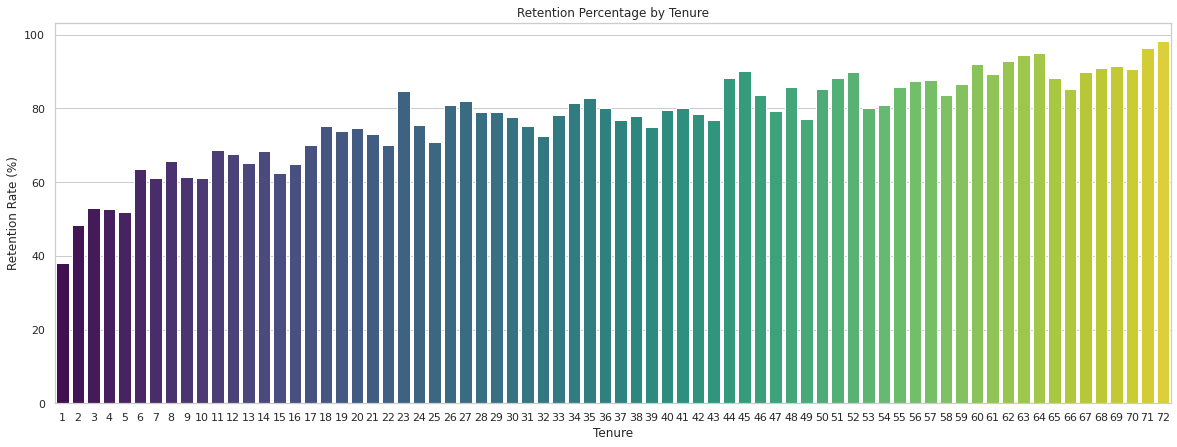

In [140]:
churn_df = (spark.sql("""select cast(tenure  as int) as tenure,
                COUNT(customerID) as Customer_Count,
                (avg(case when churn = "No" then 1 else 0 end))* 100 as Retention_percentage
                from data where tenure != 0 group by tenure order by tenure, Retention_percentage desc""")).toPandas()

plt.figure(figsize=(20, 7))
sns.set(style="whitegrid")
sns.barplot(x='tenure', y='Retention_percentage', data=churn_df, palette='viridis')
plt.title('Retention Percentage by Tenure')
plt.xlabel('Tenure')
plt.ylabel('Retention Rate (%)') 
plt.show()

Insight : As month period increases we can see the increase in the Retention_percentage. This shows that Tenure Range and Retention percentage are positively correlated. Customers tend to leave in the first few months. The longer the customer the stays , higher the chance of retention.

### b) Investigate the churn rate of customers who subscribe to streaming services like StreamingTV and StreamingMovies.

In [29]:
spark.sql("""SELECT 
    StreamingTV,
    StreamingMovies,
    COUNT(customerID) AS total_customers,
    (SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) / COUNT(customerID)) * 100 AS churn_rate
    FROM data
    WHERE StreamingTV='Yes' OR StreamingMovies='Yes'
    GROUP BY StreamingTV, StreamingMovies
    ORDER BY churn_rate
""").show()

+-----------+---------------+---------------+------------------+
|StreamingTV|StreamingMovies|total_customers|        churn_rate|
+-----------+---------------+---------------+------------------+
|        Yes|            Yes|           1940| 29.43298969072165|
|         No|            Yes|            792|31.186868686868685|
|        Yes|             No|            767|31.681877444589308|
+-----------+---------------+---------------+------------------+



### c) Write Spark SQL to group customers by their tenure (e.g., 0-12 months, 13-24 months, etc.) and analyze churn rates in these tenure groups.

<AxesSubplot:xlabel='Tenurerange', ylabel='ChurnRate'>

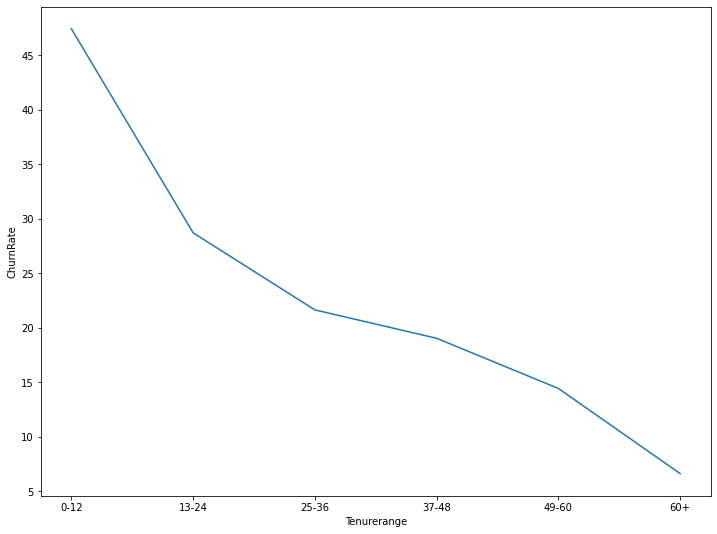

In [33]:
churned_df = spark.sql(""" 
    SELECT CASE
        WHEN tenure BETWEEN 0 AND 12 THEN '0-12'
        WHEN tenure BETWEEN 13 AND 24 THEN '13-24'
        WHEN tenure BETWEEN 25 AND 36 THEN '25-36'
        WHEN tenure BETWEEN 37 AND 48 THEN '37-48'
        WHEN tenure BETWEEN 49 AND 60 THEN '49-60'
        ELSE '60+'
    END AS Tenurerange,
    AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) * 100 ChurnRate
    FROM data
    GROUP BY Tenurerange
    ORDER BY Tenurerange
""").toPandas()

plt.figure(figsize=(12,9))
sns.lineplot(data=churned_df, x='Tenurerange',y='ChurnRate')

Insight: As the tenure increases there is a constant decrease in the churn rate. Which indicates a negative corelation between them. The longer the customer the stays, lesser the chance of retention.

### d) Analyze the impact of contract types and payment methods on churn rates.

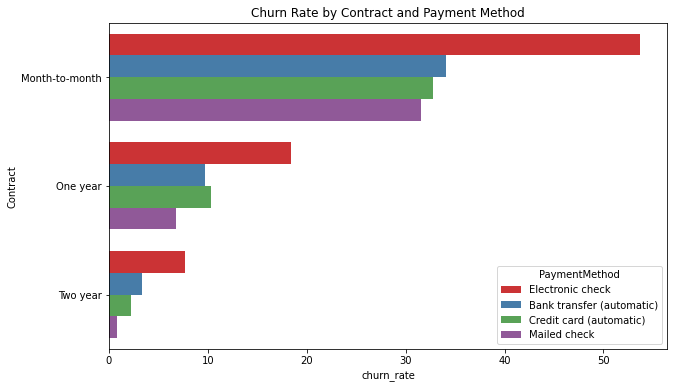

In [47]:
contract_df = spark.sql("""SELECT 
    Contract,
    PaymentMethod,
    COUNT(customerID) AS total_customers,
    SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) AS churned_customers,
    (SUM(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) / COUNT(customerID)) * 100 AS churn_rate
    FROM data
    GROUP BY Contract, PaymentMethod
    ORDER BY churn_rate desc
""").toPandas()

plt.figure(figsize=(10, 6))
sns.barplot(y=contract_df['Contract'], x=contract_df['churn_rate'],hue=contract_df['PaymentMethod'],
            palette='Set1')
plt.title('Churn Rate by Contract and Payment Method')
plt.show()

Insight : Month to Month Contract with electronic check payment has the maximum churn rate and Two year contract with Mailed check payment has least churn rate.

### e) Explore the distribution of monthly charges for customers based on their type of internet service.

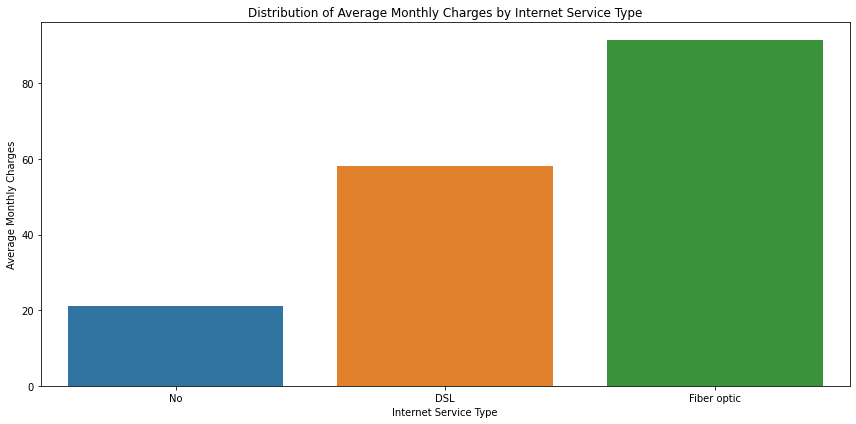

In [64]:
internet_df = spark.sql("""
    SELECT InternetService,
    COUNT(customerID) AS total_customers,
    AVG(MonthlyCharges) AS average_monthly_charge
    FROM data
    GROUP BY InternetService
    ORDER BY average_monthly_charge
""").toPandas()

plt.figure(figsize=(12, 6))
sns.barplot( x='InternetService', y='average_monthly_charge',  data=internet_df)
plt.title('Distribution of Average Monthly Charges by Internet Service Type')
plt.xlabel('Internet Service Type')
plt.ylabel('Average Monthly Charges')
plt.tight_layout()
plt.show()

Insight : Monthly charges are higher for Fibre Optic.

### f) Identify the top 10 customers who have contributed the most revenue to the company, based on total charges

In [66]:
spark.sql("""
    SELECT customerID,TotalCharges
    FROM data
    ORDER BY TotalCharges DESC
    LIMIT 10
""").toPandas()

,customerID,TotalCharges
0,9093-FPDLG,999.9
1,4536-PLEQY,999.8
2,5899-MQZZL,999.45
3,6051-PTVNS,998.1
4,8249-THVEC,997.75
5,6328-ZPBGN,997.65
6,7297-DVYGA,996.95
7,6243-OZGFH,996.85
8,0484-JPBRU,996.45
9,2971-SGAFL,995.35


### g) Calculate the churn rate segmented by gender and whether the customer is a senior citizen.

In [67]:
spark.sql("""
    SELECT gender, 
    CASE WHEN SeniorCitizen = 1 THEN 'Yes' ELSE 'No' END AS SeniorCitizen,
    AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) * 100 AS Churn_rate
    FROM data
    GROUP BY gender, SeniorCitizen
    ORDER BY gender
""").toPandas()

,gender,SeniorCitizen,Churn_rate
0,Female,No,23.938356
1,Female,Yes,42.253521
2,Male,Yes,41.114983
3,Male,No,23.280778


### h) Write query to calculate Correlation between dependents and churn. Explore whether having dependents affects customer churn rates.

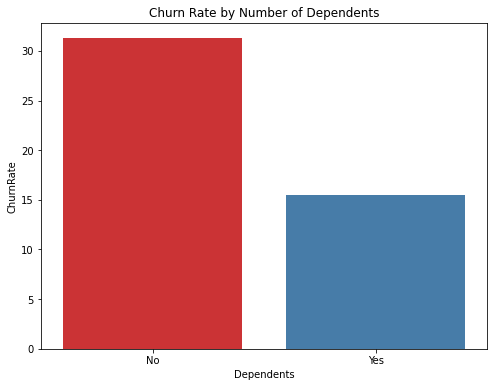

In [69]:
dependent_df = spark.sql("""
    SELECT 
    Dependents,
    AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END)*100 AS ChurnRate
    FROM data
    GROUP BY Dependents
""").toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(data=dependent_df, x='Dependents', y='ChurnRate', palette='Set1')
plt.title('Churn Rate by Number of Dependents')
plt.show()

Insight : This shows having Dependents reduces the Churn Rate by half when compared to the Customers without Dependents.

### i) Predict potential churn rates by analyzing the relationship between monthly charges, contract types, and the churn rate.

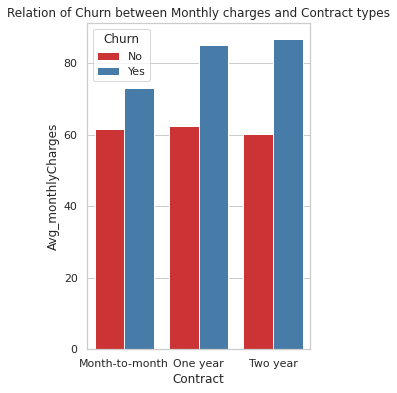

In [145]:
rel_df = spark.sql("""
    SELECT Contract, Churn, avg(MonthlyCharges) as Avg_monthlyCharges   
    FROM data group by Contract,churn order by Contract,Avg_monthlyCharges
""").toPandas()    

plt.figure(figsize=(4,6))
sns.barplot(data=rel_df, x='Contract',y='Avg_monthlyCharges',hue='Churn',palette='Set1')
plt.title('Relation of Churn between Monthly charges and Contract types')
plt.show()

Insight : Customer who have higher monthly charges tend to leave from the company.

### j) Determine the churn rate for customers who have multiple services (Phone, Internet, and Streaming), which can help understand whether bundling services leads to higher or lower churn. Calculate churn rate for customers with multiple services.

In [82]:
spark.sql("""
    SELECT 
    CASE 
    WHEN PhoneService = 'Yes' AND InternetService != 'No' AND 
    (StreamingTV = 'Yes' OR StreamingMovies = 'Yes') THEN 'Multiple Services'
    ELSE 'Single or No Service'
    END AS service,
    COUNT(customerID) AS total_customers,
    AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) * 100 AS churn_rate
    FROM data
    GROUP BY service
    ORDER BY churn_rate desc
""").toPandas()

,service,total_customers,churn_rate
0,Multiple Services,3116,31.065469
1,Single or No Service,3927,22.943723


Insight : Customers with Multiple services has high churn rate.

### k) Churn Impact by device protection and online backup services. Write query to investigate whether having device protection or online backup services affects churn rates.


In [83]:
spark.sql("""
    SELECT ROUND(AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) * 100,4) ChurnRate
    FROM data
    WHERE OnlineBackup = 'Yes' OR DeviceProtection = 'Yes'
""").toPandas()

,ChurnRate
0,23.9174


Insight : Customers with backup services or device protection has less churn rates

### l) Explore churn rates among customers who do not have phone service and investigate if it influences customer retention.

In [85]:
spark.sql("""
    SELECT PhoneService,
    AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) * 100 ChurnRate
    FROM data
    GROUP BY PhoneService
""").toPandas()

,PhoneService,ChurnRate
0,No,24.926686
1,Yes,26.709637


Insight : The customers who have Phone Service have slightly high ChurnRate than customers who has No Phone Service.

### m) Understand the relationship between payment methods and contract types on customer churn. This query will help you discover which combinations are most prone to churn.


Text(0.5, 1.0, 'Churn Rate by Contract and Payment Method')

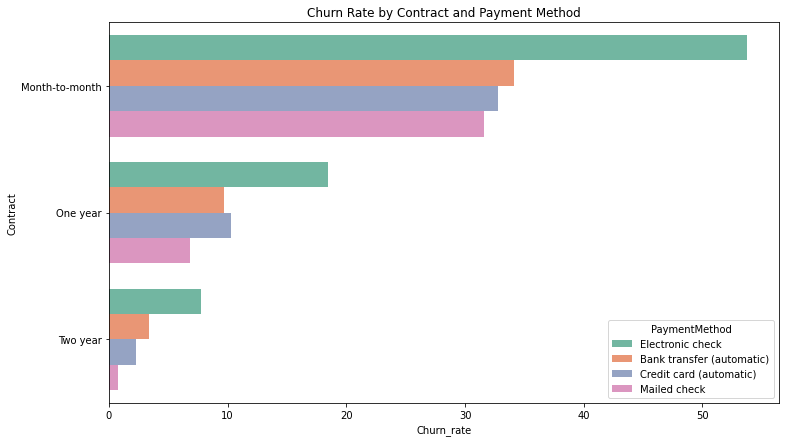

In [86]:
contracts = spark.sql( """
    SELECT Contract,PaymentMethod,
    AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) * 100 as Churn_rate
    FROM data
    GROUP BY Contract,PaymentMethod
    ORDER BY Churn_rate desc
""").toPandas()

plt.figure(figsize=(12, 7))
sns.barplot(y=contracts['Contract'], x=contracts['Churn_rate'],hue=contracts['PaymentMethod'], palette='Set2')
plt.title('Churn Rate by Contract and Payment Method')

Insight : Month-to-Month Contract type with Electronic check payment method is having high churn rate.

### n)Analyze how customer churn is affected by senior citizen status and whether the customer has dependents.


Text(0.5, 1.0, 'Churn Rate by Contract and Payment Method')

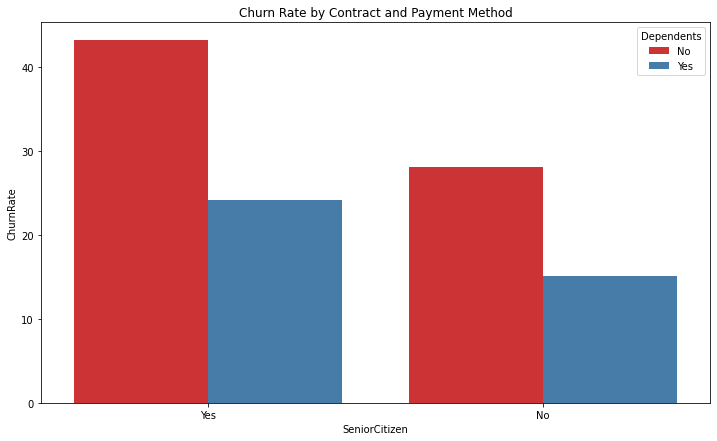

In [88]:
senior_df = spark.sql("""
    SELECT CASE WHEN SeniorCitizen=0 THEN 'No' ELSE 'Yes' END as SeniorCitizen,
    Dependents,
    AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) * 100 ChurnRate
    FROM data
    GROUP BY SeniorCitizen,Dependents
""").toPandas()
plt.figure(figsize=(12, 7))
sns.barplot(data=senior_df,x='SeniorCitizen',y='ChurnRate',hue='Dependents', palette='Set1')
plt.title('Churn Rate by Contract and Payment Method')

Insight : Customers who are Senior Citizens and having No Dependents has greater Churn Rate than the other customers.

### o) Explore whether subscribing to streaming services like Streaming TV and Streaming Movies influences the churn rate.


<AxesSubplot:xlabel='StreamingTV', ylabel='ChurnRate'>

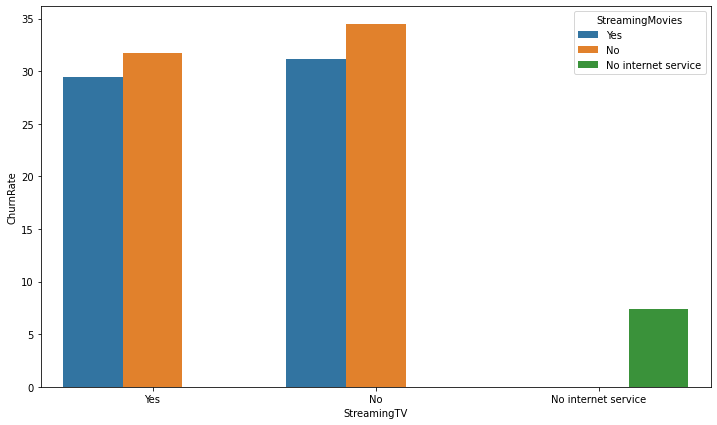

In [89]:
stream_df = spark.sql("""
        SELECT StreamingTV, StreamingMovies,
        AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) * 100 AS ChurnRate,
        COUNT(*) AS CustomerCount FROM data
        GROUP BY StreamingTV, StreamingMovies
""").toPandas()

plt.figure(figsize=(12,7))
sns.barplot(data=stream_df, x='StreamingTV',hue='StreamingMovies',y='ChurnRate')

Insight -When customers are subscribed to either tv or movie streaming,there is a small decrease in churn rate.

### p) Understand how tenure and MonthlyCharges differ between churned and non-churned customers. This can provide insights into the behavior of long-term customers.

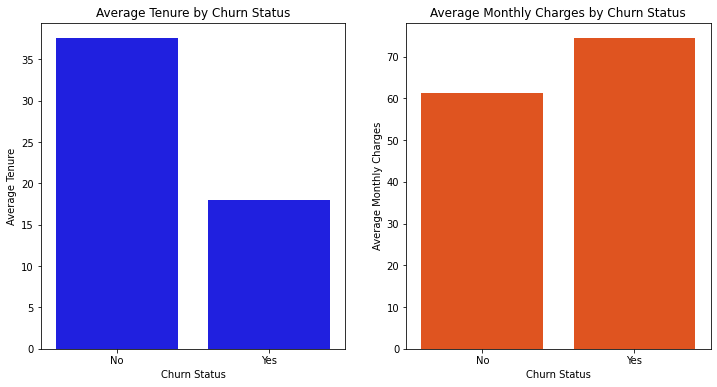

In [92]:
comp_df = spark.sql("""
    SELECT Churn,
    AVG(tenure) as AvgTenure,
    AVG(MonthlyCharges) as AvgMonthlyCharges
    FROM data
    GROUP BY Churn
""").toPandas()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.barplot(data = comp_df, x='Churn', y='AvgTenure', color='blue', ax=axes[0])
axes[0].set_title('Average Tenure by Churn Status')
axes[0].set_xlabel('Churn Status')
axes[0].set_ylabel('Average Tenure')

sns.barplot(data=comp_df, x='Churn', y='AvgMonthlyCharges', color='orangered', ax=axes[1])
axes[1].set_title('Average Monthly Charges by Churn Status')
axes[1].set_xlabel('Churn Status')
axes[1].set_ylabel('Average Monthly Charges')
plt.show()

Insight : Longer tenure is associated with lower churn rates, and higher monthly charges could be a factor making customers to leave. 

### q) Compare monthly charges and churn rates between newer customers and long-time customers.


<AxesSubplot:>

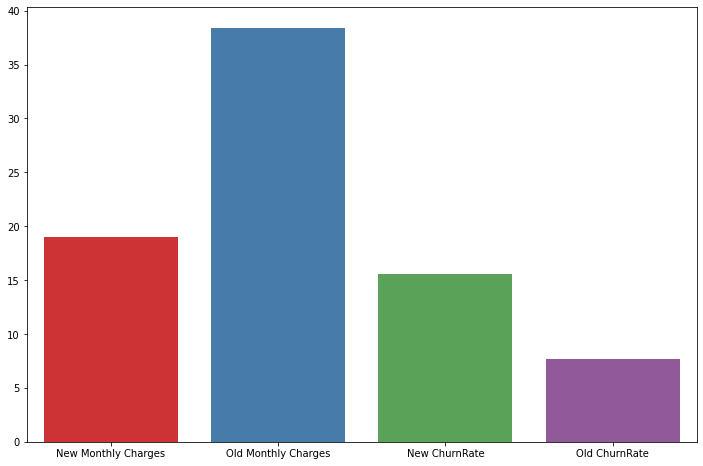

In [98]:
month_df = spark.sql("""
    SELECT
    AVG(CASE WHEN Churn = 'Yes' AND tenure < 15 THEN 1 ELSE 0 END) * 100 NewerChurn,
    AVG(CASE WHEN tenure < 15 THEN MonthlyCharges ELSE 0 END) NewerCharge,
    AVG(CASE WHEN Churn = 'Yes' AND tenure > 24 THEN 1 ELSE 0 END) * 100 olderChurn,
    AVG(CASE WHEN tenure > 24 THEN MonthlyCharges ELSE 0 END) olderCharges
    FROM data
""").toPandas()

plt.figure(figsize=(12,8))
sns.barplot( x=['New Monthly Charges','Old Monthly Charges','New ChurnRate','Old ChurnRate'],
            y=[month_df['NewerCharge'].values[0],month_df['olderCharges'].values[0],
               month_df['NewerChurn'].values[0],month_df['olderChurn'].values[0]], palette='Set1')


Insight: Churn rate is more for the newer customers and it is less for the older cusomers.

### r)What is the correlation between senior citizen status and churn rate?


Text(0.5, 1.0, 'Churn Rate of Senior Citizens')

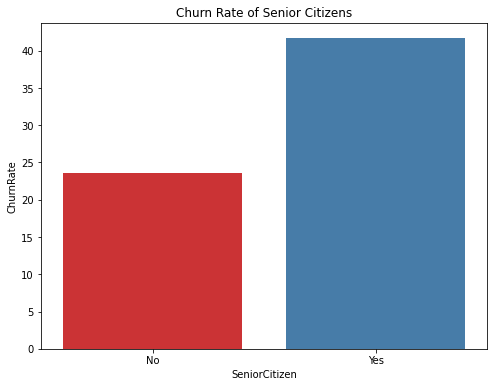

In [99]:
dependents_df = spark.sql("""
    SELECT 
    CASE WHEN SeniorCitizen = 1 THEN 'Yes' ELSE 'No' END AS SeniorCitizen,
    AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END)*100 AS ChurnRate
    FROM data
    GROUP BY SeniorCitizen
""").toPandas()

plt.figure(figsize=(8, 6))
sns.barplot(data=dependents_df, x='SeniorCitizen', y='ChurnRate', palette='Set1')
plt.title('Churn Rate of Senior Citizens')

Insight : There is an increase in Churn Rate if the customers belong to Senior Citizen Category.

### s) Partition customers based on whether they are senior citizens and divide them into 5 groups based on tenure. [Use NTILE.]

In [103]:
spark.sql("""
    SELECT 
        CustomerID,
        CASE WHEN SeniorCitizen = 1 THEN 'Yes' ELSE 'No' END AS SeniorCitizen,
        tenure,
        NTILE(5) OVER (PARTITION BY CASE WHEN SeniorCitizen = 1 THEN 'Yes' ELSE 'No' END ORDER BY tenure) AS tenure_ntile
        FROM data
    ORDER BY SeniorCitizen , tenure_ntile
""").show(30)

+----------+-------------+------+------------+
|CustomerID|SeniorCitizen|tenure|tenure_ntile|
+----------+-------------+------+------------+
|2232-DMLXU|           No|     1|           1|
|7310-EGVHZ|           No|     1|           1|
|6469-MRVET|           No|     1|           1|
|3213-VVOLG|           No|     0|           1|
|8665-UTDHZ|           No|     1|           1|
|2135-RXIHG|           No|     1|           1|
|4195-NZGTA|           No|     1|           1|
|5709-LVOEQ|           No|     0|           1|
|7644-OMVMY|           No|     0|           1|
|4075-WKNIU|           No|     0|           1|
|1066-JKSGK|           No|     1|           1|
|6380-ARCEH|           No|     1|           1|
|3091-FYHKI|           No|     1|           1|
|1024-GUALD|           No|     1|           1|
|1285-OKIPP|           No|     1|           1|
|4472-LVYGI|           No|     0|           1|
|3115-CZMZD|           No|     0|           1|
|4367-NUYAO|           No|     0|           1|
|1371-DWPAZ| 

### t) Use PERCENT_RANK to identify the top 5% of customers by MonthlyCharges.

In [106]:
spark.sql("""
    SELECT CustomerID,MonthlyCharges, MonthlyRank
    FROM (
    SELECT CustomerID,MonthlyCharges,
    PERCENT_RANK() OVER (ORDER BY MonthlyCharges) AS MonthlyRank
    FROM data) _
    WHERE MonthlyRank < 0.05
    ORDER BY MonthlyRank
""").toPandas()

,CustomerID,MonthlyCharges,MonthlyRank
0,0727-BMPLR,100,0.000000
1,3473-XIIIT,100,0.000000
2,6849-OYAMU,100,0.000000
3,7486-KSRVI,100,0.000000
4,0327-WFZSY,100,0.000000
...,...,...,...
350,8329-UTMVM,104.65,0.049702
351,3324-OIRTO,104.65,0.049702
352,5074-FBGHB,104.65,0.049702
353,8625-AZYZY,104.65,0.049702


### u) Find customers who fall within the top 5% of the distribution based on monthly charges. Compare total charges with the next customer in the same internet service type, based on monthly charges.


In [108]:
spark.sql("""
    SELECT CustomerID,InternetService,MonthlyCharges,TotalCharges,next_charge,
    ROUND((TotalCharges - next_charge),3) Charge_diff
    FROM (
    SELECT CustomerID,InternetService,MonthlyCharges,TotalCharges,
    PERCENT_RANK() OVER (ORDER BY MonthlyCharges DESC) AS MonthlyRank,
    LEAD(TotalCharges) OVER(PARTITION BY InternetService ORDER BY MonthlyCharges DESC) next_charge
    FROM data
    ) _
    WHERE MonthlyRank <= 0.05
    ORDER BY MonthlyRank
"""
).toPandas()

,CustomerID,InternetService,MonthlyCharges,TotalCharges,next_charge,Charge_diff
0,1571-SAVHK,Fiber optic,99.95,1132.75,2292.75,-1160.00
1,3511-APPBJ,Fiber optic,99.95,2292.75,3186.65,-893.90
2,1254-IZEYF,Fiber optic,99.95,3186.65,547.65,2639.00
3,3440-JPSCL,Fiber optic,99.95,547.65,3767.4,-3219.75
4,0089-IIQKO,Fiber optic,99.95,3767.4,1931.75,1835.65
...,...,...,...,...,...,...
353,1447-PJGGA,Fiber optic,95.25,5464.65,1233.65,4231.00
354,9061-TIHDA,Fiber optic,95.25,1233.65,5427.05,-4193.40
355,3207-OYBWH,Fiber optic,95.25,5427.05,3314.15,2112.90
356,2824-MYYBN,Fiber optic,95.25,3314.15,3959.35,-645.20


### v) Find the top 5 customers with the highest MonthlyCharges within each Contract type.

In [109]:
spark.sql("""
    SELECT * FROM (
    SELECT CustomerID,Contract,MonthlyCharges,
    ROW_NUMBER() OVER(PARTITION BY Contract ORDER BY MonthlyCharges) ChargeRank
    FROM data
    ) _
    WHERE ChargeRank <=5
""").toPandas()

,CustomerID,Contract,MonthlyCharges,ChargeRank
0,3473-XIIIT,Month-to-month,100,1
1,8709-KRDVL,Month-to-month,100,2
2,8397-MVTAZ,Month-to-month,100.05,3
3,1666-JXLKU,Month-to-month,100.05,4
4,2669-OIDSD,Month-to-month,100.05,5
5,0727-BMPLR,One year,100,1
6,6849-OYAMU,One year,100,2
7,7486-KSRVI,One year,100,3
8,0327-WFZSY,One year,100,4
9,9518-RWHZL,One year,100.05,5


### w) Calculate the churn rate in each Contract type and rank the contracts by churn rate.

In [111]:
spark.sql("""
    SELECT Contract,
    ROUND(AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END) ,3) ChurnRate,
    RANK() OVER(ORDER BY AVG(CASE WHEN Churn = 'Yes' THEN 1 ELSE 0 END)) ChurnRank
    FROM data
    GROUP BY Contract
""").toPandas()

,Contract,ChurnRate,ChurnRank
0,Two year,0.028,1
1,One year,0.113,2
2,Month-to-month,0.427,3


### x) Perform an in-depth analysis of customers using window functions to understand customer rankings, distribution, and trends in charges and tenure.

In [126]:
#Ranking customers based on their monthly charges for each contract type
spark.sql("""SELECT 
    customerID,
    MonthlyCharges,
    Contract,
    DENSE_RANK() OVER (PARTITION BY Contract ORDER BY MonthlyCharges DESC) AS charge_rank
    FROM data
    ORDER BY Contract, charge_rank
""").toPandas()

,customerID,MonthlyCharges,Contract,charge_rank
0,1571-SAVHK,99.95,Month-to-month,1
1,1254-IZEYF,99.95,Month-to-month,1
2,3440-JPSCL,99.95,Month-to-month,1
3,0089-IIQKO,99.95,Month-to-month,1
4,5883-GTGVD,99.95,Month-to-month,1
...,...,...,...,...
7038,8216-AZUUZ,100.4,Two year,817
7039,9028-LIHRP,100.2,Two year,818
7040,4366-CTOUZ,100.2,Two year,818
7041,2578-JQPHZ,100.1,Two year,819


Insight - The data help in targetting high ranking customers and help to avoid them from retention strategies.

In [125]:
spark.sql("""
    SELECT COUNT(*) count,
    ROUND(AVG(MonthlyCharges),3) meanCharge,
    ROUND(AVG(tenure),3) meanTenure,
    MIN(MonthlyCharges) minCharge,
    MIN(tenure) minTenure,
    Max(MonthlyCharges) maxCharge,
    Max(tenure) maxTenure,
    ROUND(STDDEV(MonthlyCharges),4) stddevCharge,
    ROUND(STDDEV(tenure),4) stddevTenure
    FROM data
""").toPandas()

,count,meanCharge,meanTenure,minCharge,minTenure,maxCharge,maxTenure,stddevCharge,stddevTenure
0,7043,64.762,32.371,100,0,99.95,9,30.09,24.5595


In [119]:
spark.sql("""SELECT 
    Contract,
    AVG(MonthlyCharges) AS avg_monthly_charge,
    AVG(tenure) AS avg_tenure
    FROM data
    GROUP BY Contract
    ORDER BY avg_tenure
""").toPandas()

,Contract,avg_monthly_charge,avg_tenure
0,Month-to-month,66.398490,18.036645
1,One year,65.048608,42.044807
2,Two year,60.770413,56.735103
